# A/B testing
---


## Problem Statement
---

**Objective** — to conduct an evaluation of the results of an A/B test. You have at your disposal a dataset containing user actions, a technical specification, and several auxiliary datasets.

In other words: Evaluate whether the changes associated with the implementation of an improved recommendation system for users have been beneficial.

## Technical Specification
---

- Test name: `recommender_system_test`
- Groups: A (Control), B (New Payment Funnel)
- Launch date: 2020-12-07
- Stop date for new user acquisition: 2020-12-21
- Stop date: 2021-01-04
- Audience: The test should include 15% of new users from the EU region.
- Test purpose: Testing changes associated with the implementation of an improved recommendation system.
- Expected number of participants: 6000
- Expected effect: Within 14 days from the registration date, users should demonstrate an improvement in each metric by at least 10%:
    - Conversion to product page views - event `product_page`
    - Cart views - `product_cart`
    - Purchases - `purchase`

## Data Description
---

**`ab_project_marketing_events.csv`** — a calendar of marketing events for the year 2020.

File structure:

- `name` — the name of the marketing event;
- `regions` — the regions where the advertising campaign will be conducted;
- `start_dt` — the start date of the campaign;
- `finish_dt` — the end date of the campaign.

**`final_ab_new_users.csv`** — users who registered from December 7th to December 21st, 2020.

File structure:

- `user_id` — user identifier;
- `first_date` — registration date;
- `region` — user's region;
- `device` — device from which the registration was performed.

**`final_ab_events.csv`** — actions of new users from December 7th, 2020 to January 4th, 2021.

File structure:

- `user_id` — user identifier;
- `event_dt` — event date and time;
- `event_name` — type of event;
- `details` — additional data about the event. For example, for purchases, the cost of the purchase in dollars is stored in this field.

**`final_ab_participants.csv`** — table of test participants.

File structure:

- `user_id` — user identifier;
- `ab_test` — test name;
- `group` — user group.

## Data Loading
---

### Library Loading
---

In [1]:
#importing lib-s and preferences
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb
import numpy as np
import matplotlib.ticker as ticker
import scipy as sc
import datetime as dt
from datetime import datetime, timedelta
import scipy.stats as stats
pd.set_option('display.max_columns', None) #for displaying all columns
pd.set_option('display.max_colwidth', None) #for displaying full widht of columns
from plotly import graph_objects as go
import plotly.express as px
import warnings; warnings.filterwarnings(action = 'ignore') #for warnings=OFF
from scipy import stats as st
import math as mth

### Data Uploading
---


In [2]:
# openning file from common directory
url1 = 'https://raw.githubusercontent.com/Bagg1n5/datasets/main/final_ab_events.csv'
url2 = 'https://raw.githubusercontent.com/Bagg1n5/datasets/main/final_ab_new_users.csv'
url3 = 'https://raw.githubusercontent.com/Bagg1n5/datasets/main/final_ab_participants.csv'
url4 = 'https://raw.githubusercontent.com/Bagg1n5/datasets/main/ab_project_marketing_events.csv'
data_events = pd.read_csv(url1)
data_users = pd.read_csv(url2)
data_participants = pd.read_csv(url3)
data_mark_events =pd.read_csv(url4)

### Functions
---


In [3]:
#function, which shows head, tail, info, description, duplicates, counts Nan's and etc. of DF

def starting_pack(data):
    print('Main info about dataframe:')
    data.info()
    print()
    print('First rows of DF:')
    display(data.head())
    print('Last rows of DF:')
    display(data.tail())
    print('Number of duplicates:')
    display(data.duplicated().sum())
    print('Number of nans:')
    display(data.isna().sum())
    print('Description:')
    display(data.describe())

In [4]:
#function, for z-test

def ztest(group1, group2, alpha = .05, n_tests = 4):

    n_tests = group1['event_name'].nunique()

    bonferroni = alpha / n_tests
    # for event in all events:
    for event in group1['event_name'].unique():

        # numbers of first actions of the single person in the group:
        successes = np.array([group1[group1['event_name'] == event]['user_id'].nunique(),
                          group2[group2['event_name'] == event]['user_id'].nunique()])

        # number of peolple in group
        trials = np.array([group1['user_id'].nunique(),
                            group2['user_id'].nunique()])

        # proportion of successes in the first group:
        p1 = successes[0]/trials[0]

        # proportion of successes in the second group:
        p2 = successes[1]/trials[1]

        # proportion of successes in the combined dataset
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # defenition of the proportions between first and second groups:
        difference = p1 - p2

        # calculation of the statistics in standard deviations of the standard normal distribution
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # set up the standard normal distribution (mean 0, standard deviation 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('Target event:', event)
        print('p-value: ', p_value)

        if p_value < bonferroni:
            print('The null hypothesis is rejected: there is a significant difference between the proportions')
            print()
        else:
            print(
                'The null hypothesis could not be rejected, there is no evidence to consider the proportions different.'
            )
            print()

## Data exploration and preprocessing
---


### final_ab_events
---
`final_ab_events.csv` — actions of new users from December 7, 2020, to January 4, 2021.

File structure:

- `user_id` — user identifier;
- `event_dt` — date and time of the event;
- `event_name` — type of event;
- `details` — additional event data. For example, for purchases, the `purchase` event contains the purchase cost in dollars.

In [5]:
starting_pack(data_events)

Main info about dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

First rows of DF:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Last rows of DF:


,user_id,event_dt,event_name,details
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
440316,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


Number of duplicates:


0

Number of nans:


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Description:


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


At first glance, the dataset seems to be fine, but we need to convert the `event_dt` column to the correct format and take a closer look at the `details` column as it has missing values.

In [6]:
#changing format of column to datetime
data_events['event_dt'] = pd.to_datetime(data_events['event_dt'])
data_events.info()
display(data_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [7]:
print(sorted(data_events['details'].unique()))

[4.99, 9.99, 99.99, 499.99, nan]


The column contains values such as 4.99, 9.99, 99.99, 499.99, and nan. Referring back to the dataset description, these are additional details about the event. For instance, for purchases (`purchase`), this field stores the cost of the purchase in dollars.

Since the event "purchase" is in the `event_name` column - investigating it as well.

In [8]:
print(data_events['event_name'].unique())

['purchase' 'product_cart' 'product_page' 'login']


There are a total of 4 event types. Checking if all "purchase" events have a price in the "details" column.

In [9]:
print('The length of the dataframe with event_name = "purchase" and filled price in the "details" column:', len(data_events.query('event_name == "purchase" and details.notnull()')))

The length of the dataframe with event_name = "purchase" and filled price in the "details" column: 62740


Checking the distribution of events.

In [10]:
events_by_users = (data_events
                   .groupby('event_name')
                   .agg(count=('user_id','count'),unique_user=('user_id','nunique'))
                   .sort_values(by='count',ascending=False)
                   .reset_index()
)
events_by_users['mean'] = round(events_by_users['count']/events_by_users['unique_user'],2)
display(events_by_users)
print('The average number of events per user in the entire dataframe is:',round(data_events['user_id'].count()/data_events['user_id'].nunique(),2))

,event_name,count,unique_user,mean
0,login,189552,58697,3.23
1,product_page,125563,38929,3.23
2,purchase,62740,19569,3.21
3,product_cart,62462,19284,3.24


The average number of events per user in the entire dataframe is: 7.5


The time period of the dataset is:

In [11]:
print('The date of the initial event is:', data_events['event_dt'].min())
print('The date of the final event is:', data_events['event_dt'].max())

The date of the initial event is: 2020-12-07 00:00:33
The date of the final event is: 2020-12-30 23:36:33


**In the technical specification**, it is stated:
> ...in the period from December 7, 2020, to January 4, 2021.

**In reality**, the dataset covers the period from December 7, 2020, to December 30, 2020.

As a result, it appears that the dataset is incomplete, or there might be errors in the provided technical specification. This discrepancy should be taken into consideration during the analysis and interpretation of the results.

The distribution of events over time:

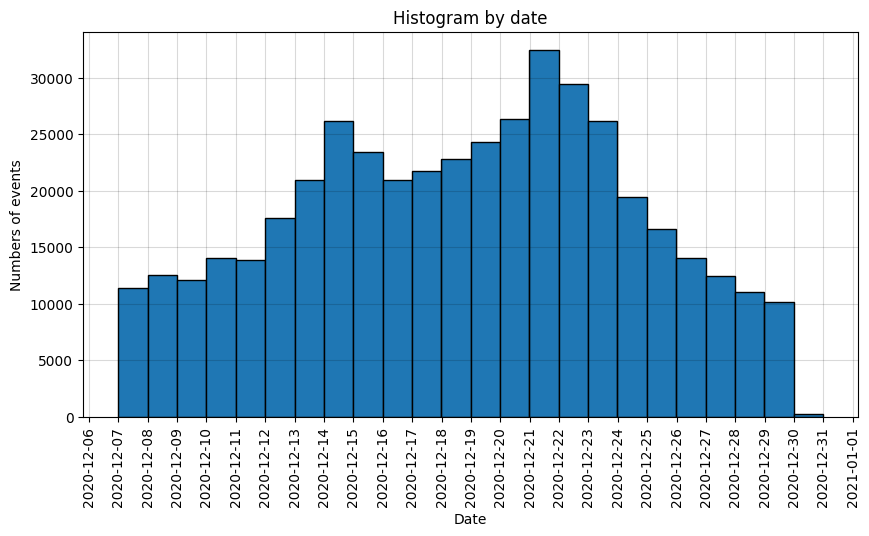

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
#figure
ax.hist(data_events['event_dt'], bins = 24, edgecolor="black")

#OXY, Title names
ax.set_xlabel('Date')
ax.set_ylabel('Numbers of events')
ax.set_title('Histogram by date');

#grid major
ax.grid(which='major',
       color = 'black',
       alpha=0.15)

#tickers
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#xticks rotation
plt.xticks(rotation=90);

The graph shows that there are two spikes of activity: on December 14th and December 21st. However, on December 30th, the number of user actions noticeably dropped.

In [13]:
print('The number of registered user actions on 30.12:',len(data_events.query('event_dt > "2020-12-29 23:59:59"')))

The number of registered user actions on 30.12: 89


Looks interesting. Checking the distribution of actions by time of day:

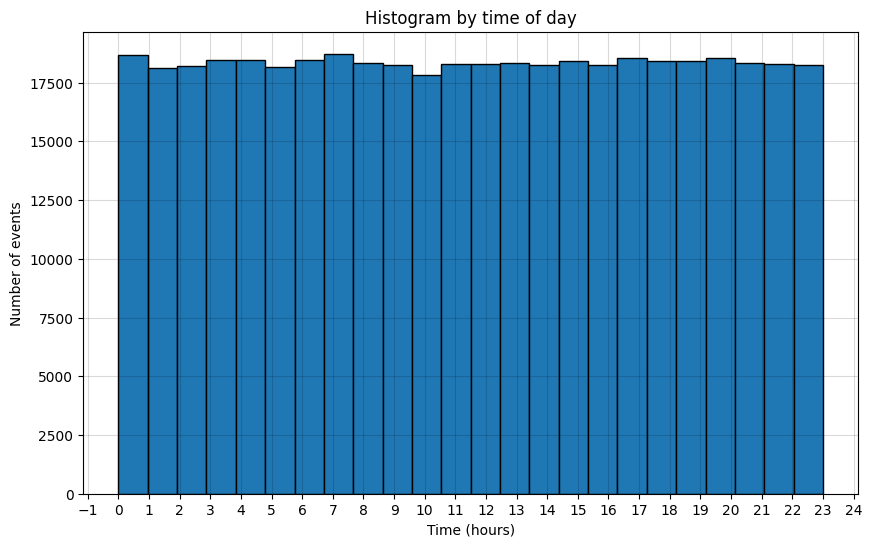

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
#figure
ax.hist(data_events['event_dt'].dt.hour, bins = 24, edgecolor="black")

#OXY, Title names
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Number of events')
ax.set_title('Histogram by time of day');

#tickers
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#grid major
ax.grid(which='major',
       color = 'black',
       alpha=0.15);

Events by time of day are distributed almost equally. I'm confirming this by adding an "hour" column to the dataset:

In [15]:
data_events['hour'] = data_events['event_dt'].dt.hour
data_events.groupby('hour').agg(count=('user_id','count'))

,count
hour,
0,18661
1,18142
2,18219
3,18463
4,18444
5,18181
6,18448
7,18729
8,18341


### final_ab_new_users
---
`final_ab_new_users.csv` — users who registered from December 7 to December 21, 2020.

File structure:

- `user_id` — user identifier;
- `first_date` — registration date;
- `region` — user's region;
- `device` — device used for registration.

In [16]:
starting_pack(data_users)

Main info about dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

First rows of DF:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Last rows of DF:


,user_id,first_date,region,device
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone
61732,8F04273BB2860229,2020-12-20,EU,Android


Number of duplicates:


0

Number of nans:


user_id       0
first_date    0
region        0
device        0
dtype: int64

Description:


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


There are no missing values, the date format needs to be adjusted accordingly. Сhecking the values in the "region" column, and also proceed with the devices.

In [17]:
#changing format of column to datetime
data_users['first_date'] = pd.to_datetime(data_users['first_date'])
data_users.info()
display(data_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [18]:
data_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

Let's decode the abbreviations:
* EU - Europe;
* N.America - North America;
* APAC - Asia-Pacific,
> Asia-Pacific is a political and economic term that refers to countries located around the perimeter of the Pacific Ocean and numerous island nations within the ocean;
* CIS - Commonwealth of Independent States.

Finding out the start and end dates:

In [19]:
print('First date of event:', data_users['first_date'].min())
print('Last date of event:', data_users['first_date'].max())

First date of event: 2020-12-07 00:00:00
Last date of event: 2020-12-23 00:00:00


Another inconsistency in dates:

In the task description:
> from December 7 to **December 21, 2020**.

In reality:
> Last event date: **2020-12-23** 00:00:00

I conclude that **the dataset is extended, or the task description contains errors.**

In [20]:
data_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

I will check how the first events are distributed by days:

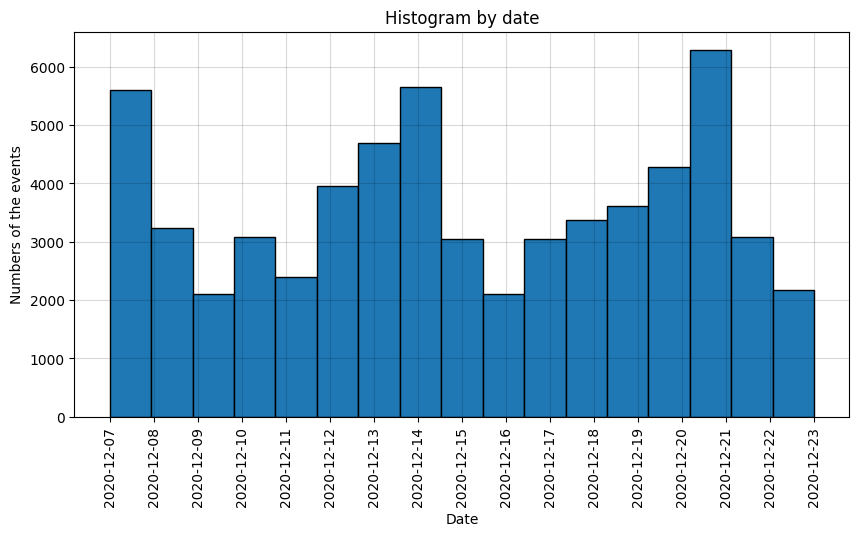

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
#figure
ax.hist(data_users['first_date'], bins = 17, edgecolor="black")

#OXY, Title names
ax.set_xlabel('Date')
ax.set_ylabel('Numbers of the events')
ax.set_title('Histogram by date');

#grid major
ax.grid(which='major',
       color = 'black',
       alpha=0.15)

#tickers
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#xticks rotation
plt.xticks(rotation=90);

It's interesting indeed. The spikes in registrations are on December 14th and 21st. It's the second mention of these dates. Most likely, there were some holidays on these dates. However, there's also a spike in registrations on December 7th.

I will see how users are distributed across devices and regions.

In [22]:
data_users.groupby('device').agg(count_unique=('user_id', 'nunique'), count=('user_id', 'count'))

,count_unique,count
device,,
Android,27520,27520
Mac,6084,6084
PC,15599,15599
iPhone,12530,12530


Users who registered from Android devices are almost twice as many as the others. Registrations from PCs are the lowest. One unique registration corresponds to one device.

In [23]:
data_users.groupby('region').agg(count_unique=('user_id', 'nunique'), count=('user_id', 'count'))

,count_unique,count
region,,
APAC,3153,3153
CIS,3155,3155
EU,46270,46270
N.America,9155,9155


The majority of users registered from Europe.

### final_ab_participants
---
`final_ab_participants.csv` — table of test participants.

File structure:

- `user_id` — user identifier;
- `ab_test` — test name;
- `group` — user group.

In [24]:
starting_pack(data_participants)

Main info about dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

First rows of DF:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Last rows of DF:


,user_id,group,ab_test
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test
18267,79F9ABFB029CF724,B,interface_eu_test


Number of duplicates:


0

Number of nans:


user_id    0
group      0
ab_test    0
dtype: int64

Description:


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


No missing values, need to check if users are in both groups and the specifics of the A/B test.

In [25]:
data_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Two types of tests. How are users distributed?

In [26]:
data_participants.groupby('ab_test').agg(count_unique=('user_id', 'nunique'), count=('user_id', 'count'))

,count_unique,count
ab_test,,
interface_eu_test,11567,11567
recommender_system_test,6701,6701


Again, a mismatch with the technical task:
> Test purpose: testing changes related to the implementation of an improved **recommendation system**;

In the data:
> '**recommender**_system_test', 'interface_eu_test'

Let's assume that due to an error, two datasets have been combined.

Let's look at the users and their assignment to both groups of the A/B test for 'recommender_system_test'.

In [27]:
# filtering test-specs
data_participants_true = data_participants.query('ab_test == "recommender_system_test"')

In [28]:
both_group = data_participants_true.groupby('user_id').agg({'group':'nunique'}).query('group > 1').reset_index()
both_list = both_group['user_id'].tolist()
participants = data_participants_true.query('user_id not in @both_list')
print('Size of data_participants_true:',len(data_participants_true))
print('Unique users:',data_participants_true['user_id'].nunique())
print('Users in group А:',len(data_participants_true.query('group == "A"')))
print('Users in group В:',len(data_participants_true.query('group == "B"')))
print('UNIQUE users in group А:',data_participants_true.query('group == "A"')['user_id'].nunique())
print('UNIQUE users in group B:',data_participants_true.query('group == "B"')['user_id'].nunique())
print('Users, who is in BOTH groups:',both_group['user_id'].nunique())
print('Dataset size without BOTH groups usres:',participants['user_id'].nunique())

Size of data_participants_true: 6701
Unique users: 6701
Users in group А: 3824
Users in group В: 2877
UNIQUE users in group А: 3824
UNIQUE users in group B: 2877
Users, who is in BOTH groups: 0
Dataset size without BOTH groups usres: 6701


Now I will look at the users from another test who could have been included in the test under investigation:

In [29]:
both_tests_df = data_participants.groupby('user_id').agg(count=('user_id','count')).query('count > 1').reset_index()
both_tests_ids = both_tests_df['user_id'].tolist()
print('The number of users who are included in both tests:',len(both_tests_ids))


The number of users who are included in both tests: 1602


I will take a look at the filtered dataset of test participants who only took part in the required test:


In [30]:
data_participants_filtered = data_participants_true.query('user_id not in @both_tests_ids')

both_group_2 = data_participants_filtered.groupby('user_id').agg({'group':'nunique'}).query('group > 1').reset_index()
both_list_2 = both_group_2['user_id'].tolist()
participants_2 = data_participants_filtered.query('user_id not in @both_list')

print('Size data_participants_filtered:',len(data_participants_filtered))
print('Unique users:',data_participants_filtered['user_id'].nunique())
print('Users in group А:',len(data_participants_filtered.query('group == "A"')))
print('Users in group В:',len(data_participants_filtered.query('group == "B"')))
print('UNIQUE users in group А:',data_participants_filtered.query('group == "A"')['user_id'].nunique())
print('UNIQUE users in group B:',data_participants_filtered.query('group == "B"')['user_id'].nunique())
print('Users, who is in BOTH groups:',both_group_2['user_id'].nunique())
print('Dataset size without BOTH groups usres:',participants_2['user_id'].nunique())

Size data_participants_filtered: 5099
Unique users: 5099
Users in group А: 2903
Users in group В: 2196
UNIQUE users in group А: 2903
UNIQUE users in group B: 2196
Users, who is in BOTH groups: 0
Dataset size without BOTH groups usres: 5099


Alright, we have the dataset `data_participants_filtered` now, where:
1. There are no users who participated in both tests.
2. There are no users who ended up in both A/B test groups.

### ab_project_marketing_events
---
`ab_project_marketing_events.csv` — marketing events calendar for the year 2020.

File structure:

- `name` — name of the marketing event;
- `regions` — regions where the advertising campaign will be conducted;
- `start_dt` — start date of the campaign;
- `finish_dt` — end date of the campaign.

In [31]:
starting_pack(data_mark_events)

Main info about dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

First rows of DF:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Last rows of DF:


,name,regions,start_dt,finish_dt
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Number of duplicates:


0

Number of nans:


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Description:


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


There are 14 marketing events, among which there are some that do not intersect with our data. I will change the formats of the date columns and filter only the relevant ones (starting from December 7th).

In [32]:
#changing format of column to datetime
data_mark_events['start_dt'] = pd.to_datetime(data_mark_events['start_dt'])
data_mark_events['finish_dt'] = pd.to_datetime(data_mark_events['finish_dt'])
data_mark_events.info()
display(data_mark_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [33]:
data_mark_events.query('finish_dt > "2020-12-06 23:59:59"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


The test is affected by two events: "Christmas&New Year Promo" for the regions EU, N.America, and CIS, and "New Year Gift Lottery".

### Conclusion for the Section:
---
* **data_events**
1. The nature of the missing values is clear: additional information for purchases.
2. Discrepancy in dates with the technical specification: In the technical specification, the period is stated as from December 7, 2020, to January 4, 2021, while in the dataset, it is from December 7, 2020, to December 30, 2020 (the dataset is incomplete or the technical specification has errors).
3. The data for December 30th is incomplete in the dataset, with a total of only 89 events. It's possible that we might exclude this day during preprocessing.
4. The distribution of events over dates shows two spikes in activity: on December 14th and December 21st.

* **data_users**
1. Users are distributed across 4 regions, with the European region being the most prevalent.
2. Discrepancy in dates with the technical specification: In the technical specification, the period is stated as from December 7, 2020, to December 21, 2020, while in the dataset, it is from December 7, 2020, to December 23, 2020 ( the dataset has been extended).
3. Spikes in registrations are observed on December 14th and December 21st. These dates are mentioned multiple times, and they likely correspond to holidays. However, there is also a spike in registrations on December 7th.

* **data_participants**
1. Again, a discrepancy with the technical specification: The dataset contains two tests - '**recommender_system_test' (the one we need)** and 'interface_eu_test'.
2. A new dataset has been created with users participating only in the 'recommender_system_test' (Groups A and B).

* **data_mark_events**
1. Two events are identified that could interfere with the A/B test: Christmas&New Year Promo for the EU and N.America regions from December 25th, 2020, to January 2nd, 2021; CIS New Year Gift Lottery from December 30th, 2020, to January 7th, 2021.

## Exploratory Data Analysis
---

### Data Filtering
---


Since during the data exploration and preprocessing stage, a dataset **`data_participants_filtered`** was created, in which:
* there are no users who participated in both tests;
* there are no users who ended up in both groups of the A/B test.

Now, we need to remove users who registered after December 21, 2020, and didn't perform any actions within the test timeframe (2 weeks: from December 21, 2020, to January 4, 2021).

In [34]:
data_users_filtered = data_users.query('first_date <= "2020-12-21 23:59:59"')
print('Register date from:', data_users_filtered['first_date'].min())
print('Till:', data_users_filtered['first_date'].max())
print('users who registered BEFORE 21.12.20 (including):',data_users_filtered['user_id'].nunique())

Register date from: 2020-12-07 00:00:00
Till: 2020-12-21 00:00:00
users who registered BEFORE 21.12.20 (including): 56470


Users who registered after December 21, 2020, have been filtered out.

Next, I will remove those who didn't perform any actions from December 21, 2020, to January 4, 2021.

Since all the information about user actions is contained in the **data_events** dataframe, a new dataset **data_test_logs** needs to be created:

1. Keep users who registered before December 21, 2020 (data_users_filtered).
2. Retain information about users who were in the control groups of the test (data_participants_filtered) and check how users who entered the required test relate to the expected number of test participants (6000 users according to the technical specification). Additionally, we will verify their proportion (which should be 15% as per the specification).
3. Keep users who performed actions within the test period from December 21, 2020, to January 4, 2021, for the A/B test analysis.

1. I will merge the tables `data_events` and `data_users_filtered` into `data_events_filtered`:

In [35]:
data_events_new = data_events.merge(data_users_filtered, on='user_id', how='right')
print('Users who registered on or before December 21, 2020 (inclusive), in the dataset along with their actions:',data_events_new['user_id'].nunique())

Users who registered on or before December 21, 2020 (inclusive), in the dataset along with their actions: 56470


2. I will keep only the participants from the `data_participants_filtered` test in the `data_events_new` table:

In [36]:
data_events_new = data_events_new.merge(data_participants_filtered, on='user_id', how='right')
print('Users who registered before December 21, 2020 (inclusive) and are participating in the test, along with their actions, in the dataset:',data_events_new['user_id'].nunique())
print('Actions total:',len(data_events_new))

Users who registered before December 21, 2020 (inclusive) and are participating in the test, along with their actions, in the dataset: 5099
Actions total: 21115


There is a discrepancy with the technical specification:

> Expected number of test participants: 6000

Actual number:

> 5099

I will check how the users selected for the test are distributed across regions:

In [37]:
data_events_new.groupby('region').agg(users=('user_id','nunique'))

,users
region,
APAC,72
CIS,55
EU,4749
N.America,223


In [38]:
print('Total users from EU:', data_users.query('region == "EU"')['user_id'].nunique())

Total users from EU: 46270


In [39]:
print('The ratio of test users from the EU region to all participants of the test from the EU:', round(data_participants_filtered['user_id'].nunique()/data_users.query('region == "EU"')['user_id'].nunique()*100,2),"%")

The ratio of test users from the EU region to all participants of the test from the EU: 11.02 %


Once again, there's a discrepancy with the initial requirements:

> The test should include 15% of new users from the EU region;

In reality:

> The proportion of users from Europe selected for A/B testing: 11.02%

How are users distributed among the groups?

In [40]:
data_events_new.groupby('group').agg(users=('user_id','nunique'))

,users
group,
A,2903
B,2196


In Group A, there are significantly more users than in Group B. I will check how their actions are distributed.

In [41]:
data_events_new.groupby('group').agg(users=('user_id','nunique'), events=('event_dt','count'))

,users,events
group,,
A,2903,14737
B,2196,4067


It's possible that users in Group B didn't perform any actions within the test. I will look into this in the next step.

### Analysis of the A/B Test Sample
---

Now I will create the **data_test_logs** dataset, in which the following conditions will be met:
1. The required test is recommender_system_test.
2. Participants of the test registered before December 21, 2020.
3. **Test participants performed actions within 14 days from the registration date.**

In [42]:
data_test_logs = data_events_new.copy()
data_test_logs['action_days'] = data_test_logs['event_dt'] - data_test_logs['first_date']
data_test_logs['action_days'] = data_test_logs['action_days'].astype('timedelta64[D]')
data_test_logs = data_test_logs.query('action_days <= 14')
data_test_logs

,user_id,event_dt,event_name,details,hour,first_date,region,device,group,ab_test,action_days
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99,14.0,2020-12-07,EU,PC,A,recommender_system_test,0.0
2,D1ABA3E2887B6A73,2020-12-07 14:43:29,product_cart,NaN,14.0,2020-12-07,EU,PC,A,recommender_system_test,0.0
4,D1ABA3E2887B6A73,2020-12-07 14:43:27,product_page,NaN,14.0,2020-12-07,EU,PC,A,recommender_system_test,0.0
6,D1ABA3E2887B6A73,2020-12-07 14:43:27,login,NaN,14.0,2020-12-07,EU,PC,A,recommender_system_test,0.0
8,A7A3664BD6242119,2020-12-20 15:46:06,product_page,NaN,15.0,2020-12-20,EU,iPhone,A,recommender_system_test,0.0
...,...,...,...,...,...,...,...,...,...,...,...
21110,6715343AFBA285AE,2020-12-07 10:12:15,login,NaN,10.0,2020-12-07,CIS,Android,B,recommender_system_test,0.0
21111,6715343AFBA285AE,2020-12-08 22:51:16,login,NaN,22.0,2020-12-07,CIS,Android,B,recommender_system_test,1.0
21112,6715343AFBA285AE,2020-12-09 02:28:03,login,NaN,2.0,2020-12-07,CIS,Android,B,recommender_system_test,2.0
21113,6715343AFBA285AE,2020-12-10 22:55:14,login,NaN,22.0,2020-12-07,CIS,Android,B,recommender_system_test,3.0


The dataframe with events has been significantly reduced compared to the initial one.

Now I will take a look at the groups:

In [43]:
data_test_logs.groupby('group').agg(users=('user_id','nunique'), events=('event_dt','count'))

,users,events
group,,
A,2082,14459
B,706,3870


Indeed, it turns out that users in group B are less active compared to group A.

I will now look at the overall distributions for the remaining features:

In [44]:
data_test_logs.groupby('region').agg(users=('user_id','nunique'), events=('event_dt','count'))

,users,events
region,,
APAC,45,225
CIS,30,199
EU,2594,17087
N.America,119,818


In [45]:
data_test_logs.groupby('device').agg(users=('user_id','nunique'), events=('event_dt','count'))

,users,events
device,,
Android,1248,8117
Mac,252,1736
PC,714,4542
iPhone,574,3934


For the events, I will create a funnel:

In [46]:
events_from_clear_logs = (data_test_logs
                       .groupby('event_name')
                       .agg({'user_id':'nunique'})
                       .rename(columns = {'user_id':'unique_users'})
                       .sort_values(by='unique_users',ascending=False)
                      ).reset_index()

events_from_clear_logs['percentage'] = round(events_from_clear_logs['unique_users']/data_test_logs['user_id'].nunique()*100,2)
events_from_clear_logs

,event_name,unique_users,percentage
0,login,2787,99.96
1,product_page,1757,63.02
2,purchase,850,30.49
3,product_cart,826,29.63


It turns out that users make purchases more often than they view the cart.

Rearranging the rows and prepare a table for the funnel.

In [47]:
vortex = events_from_clear_logs.head(4).copy()
vortex['percentage'] = round(vortex['percentage'] / vortex['percentage'].shift(1),2)*100
vortex['place'] = [1,2,4,3]
vortex = vortex.sort_values(by='place',ascending=True)

In [48]:
#making funnel
fig = go.Figure(go.Funnel(y = vortex['event_name'], #event
                          x = vortex['unique_users'], #values of counting
                          textposition = "inside",  #text pos: ("top center",
                                                    # "middle left", "top center",
                                                    # "bottom center", "top right",
                                                    # "middle left", "bottom right",
                                                    # "bottom left", "top right","top right")
                          textinfo = "value + percent previous + percent initial", # "label" "value+percent previous+percent initial"
                          opacity = 1,
                          connector = {"line": {"color": "blue", "dash": "dot", "width": 3}})
               )
#Title
fig.update_layout(title_text='Actions funnel',
                  title_x=0.5
                 )


fig.show();

1. After login, 63% of users proceed to the next step (37% are lost at this stage).
2. Viewing the cart is done by 47% (30% of the initial number of users).
**Interesting feature:** Users view the cart less often than they make a purchase. Most likely, there is a quick purchase button on the website.
3. Purchases are made by 103% of those who viewed the cart (30% of the initial).

The event funnel broken down by Group A and Group B.

In [49]:
events_from_clear_logs_by_group = (data_test_logs
                       .groupby(['group','event_name'])
                       .agg({'user_id':'nunique'})
                       .rename(columns = {'user_id':'unique_users'})
                      ).reset_index()

events_from_clear_logs_by_group

,group,event_name,unique_users
0,A,login,2082
1,A,product_cart,631
2,A,product_page,1360
3,A,purchase,652
4,B,login,705
5,B,product_cart,195
6,B,product_page,397
7,B,purchase,198


In [50]:
vortex_group = events_from_clear_logs_by_group.copy()
vortex_group
vortex_group['place'] = [1,3,2,4,5,7,6,8]
vortex_group = vortex_group.sort_values(by='place',ascending=True)
vortex_group

,group,event_name,unique_users,place
0,A,login,2082,1
2,A,product_page,1360,2
1,A,product_cart,631,3
3,A,purchase,652,4
4,B,login,705,5
6,B,product_page,397,6
5,B,product_cart,195,7
7,B,purchase,198,8


In [51]:
#making funnel
fig = go.Figure()

fig.add_trace(go.Funnel(y = vortex_group.query('group == "A"')['event_name'], #event
                       x = vortex_group.query('group == "A"')['unique_users'], #values of counting
                       textposition = "inside",  #text pos: ("top center",
                                                    # "middle left", "top center",
                                                    # "bottom center", "top right",
                                                    # "middle left", "bottom right",
                                                    # "bottom left", "top right","top right")
                       textinfo = "value + percent previous + percent initial", # "label" "value+percent previous+percent initial"
                       opacity = 1,
                       name = 'A',
                       connector = {"line": {"color": "blue", "dash": "dot", "width": 3}})
               )

fig.add_trace(go.Funnel(y = vortex_group.query('group == "B"')['event_name'], #event
                       x = vortex_group.query('group == "B"')['unique_users'], #values of counting
                       textposition = "inside",  #text pos: ("top center",
                                                    # "middle left", "top center",
                                                    # "bottom center", "top right",
                                                    # "middle left", "bottom right",
                                                    # "bottom left", "top right","top right")
                       textinfo = "value + percent previous + percent initial", # "label" "value+percent previous+percent initial"
                       opacity = 1,
                       name = 'B',
                       connector = {"line": {"color": "red", "dash": "dot", "width": 3}})
               )
#Title
fig.update_layout(title_text='Event funnel breakdown by groups',
                  title_x=0.5
                 )


fig.show();

The conversion rates in the groups are approximately the same, with group B slightly lagging behind.

I will now take a look at the A/B test's lifetime graph.

In [52]:
fig = px.histogram(data_test_logs, x="event_dt", color="group", nbins=24)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)

fig.update_layout(
    title_text='Histogram of A/B test duration with the addition of marketing events.', # title of plot
    xaxis_title_text='Data', # xaxis label
    yaxis_title_text='Numbers of events', # yaxis label
)

#Christmas&New Year Promo rectangle
fig.add_vrect(x0="2020-12-23", x1="2021-01-03",
              annotation_text="Christmas&New Year Promo", annotation_position="top left",
              fillcolor="pink", opacity=0.25, line_width=0)
#CIS New Year Gift Lottery rectangle
fig.add_vrect(x0="2020-12-30", x1="2021-01-07",
              annotation_text="CIS New Year Gift Lottery", annotation_position="top left",
              fillcolor="orange", opacity=0.25, line_width=0)
#End lene of the test
fig.add_vline(
        x="2021-01-04", line_width=3, line_dash="dash",
        line_color="green")
#Start line of the test
fig.add_vline(
        x="2020-12-07", line_width=3, line_dash="dash",
        line_color="green")
#End of the registrations
fig.add_vline(
        x="2020-12-21", line_width=3, line_dash="dash",
        line_color="red")

fig.show()

The green vertical lines represent the test boundaries, the red line indicates the end of new user registrations, and the shaded areas correspond to overlapping marketing events.

1. **The A/B test is being conducted with errors:**
   - Two marketing events took place within the testing timeframe (Christmas&New Year Promo for EU and N.America regions from 25.12.20 to 2.01.21; CIS New Year Gift Lottery from 30.12.20 to 7.01.21).
   - The data is incomplete (no data for 30.12.20-04.01.21).
   - The number of participants in the test groups differs almost threefold (Group A: 2082, Group B: 706).

2. **Results of the funnel analysis for events in groups A/B:**
   - After login, 65/56% of users proceed to the next step (35/44% drop off at this stage).
   - 46/49% of users view the shopping cart (30/28% of the initial user count).

**Interesting observation:** Users view the shopping cart less frequently than they make purchases. This suggests that there might be a quick purchase button on the website.
   - Users make purchases of products at 103/102% compared to those who viewed the shopping cart (31/28% of the initial user count).

### Checking Statistical Hypotheses Using the Z-Test
---

Let's write a function that takes two datasets, a significance level (default is 0.05), the number of tests (default is the number of events for each group, for Bonferroni correction), and the answer will be based on the question **"Do the statistical criteria indicate a difference between the groups for the target event: %event_name%"**.

For our statistical test, we need to check 3 events: **product_page, product_cart, purchase**, as the conversion rates within groups differ, whereas for the **login** event, they do not.

The hypotheses will be formulated as follows:

* **H0:** The proportions of users in the groups at this stage of the funnel are **equal**.
* **H1:** The proportions of users in the groups at this stage of the funnel are **different**.

In [53]:
data_test_logs_z = data_test_logs.query('event_name != "login"')

In [54]:
ztest(data_test_logs_z[data_test_logs_z['group'] == "A"], data_test_logs_z[data_test_logs_z['group'] == "B"], alpha = 0.05, n_tests = 3)

Target event: purchase
p-value:  0.5568896338538505
The null hypothesis could not be rejected, there is no evidence to consider the proportions different.

Target event: product_cart
p-value:  0.7578720909128716
The null hypothesis could not be rejected, there is no evidence to consider the proportions different.

Target event: product_page
p-value:  0.0035102485783522486
The null hypothesis is rejected: there is a significant difference between the proportions



Yes, indeed, between the groups, there is a significant difference when transitioning to the product page, with a notable gap of 9%, compared to the 2-3% differences observed at the other stages.

## Conclusion
---
Four datasets were obtained, studied, and processed:

* **data_events**
1. The nature of missing values is clear: additional information in case of a purchase;
2. Discrepancy in the dates according to the task: The task specifies from December 7, 2020 to January 4, 2021, while the actual data is from December 7, 2020 to December 30, 2020 (We conclude that the dataset is incomplete or there are errors in the task).
3. The date December 30 is incomplete in the dataset, with only 89 actions recorded. It is possible that this day should be excluded from the analysis.
4. The distribution of events by date shows two spikes in activity: December 14 and December 21.

* **data_users**
1. Users are distributed among 4 regions, with the European region being the most prevalent.
2. Discrepancy in the dates according to the task: The task specifies from December 7, 2020 to December 21, 2020, while the actual data is from December 7, 2020 to December 23, 2020 (We conclude that the dataset is extended).
3. Registration spikes occur on December 14 and December 21. These dates may have been holidays. Additionally, there is another spike on December 7.

* **data_participants**
1. Another discrepancy with the technical task: the data contains two tests - **'recommender_system_test' (the one we need)** and 'interface_eu_test'.
2. A new dataset was created containing only users participating in the 'recommender_system_test' (Groups A and B).

* **data_mark_events**
1. Two events were identified that could affect the A/B test: Christmas&New Year Promo for the EU and N.America regions from December 25, 2020, to January 2, 2021; CIS New Year Gift Lottery from December 30, 2020, to January 7, 2021.

---

Based on the results of the exploratory data analysis, the following conclusions were drawn:

1. **The A/B test is conducted with errors:**
* Two marketing events took place during the test period (Christmas&New Year Promo for the EU and N.America regions from December 25, 2020, to January 2, 2021; CIS New Year Gift Lottery from December 30, 2020, to January 7, 2021).
* The data is incomplete (no data for December 30, 2020, to January 4, 2021).
* The number of participants in the test groups differs by almost three times (A: 2082, B: 706).

2. **Results of the analysis of event funnels for groups A/B:**
* After logging in, 65/56% of users proceed to the next step (35/44% drop at this step);
* 46/49% of users view the cart (30/28% of the initial number of users);

**Interesting observation:** Users view the cart less frequently than they make a purchase. This could be due to the presence of a quick purchase button on the website.
* Users purchase products at a rate of 103/102% compared to those who view the cart (31/28% of the initial number of users).


---

**In summary:** The implementation of the new payment funnel is not effective.